# Kryptos — The Unsolved Fourth Tableau

## Assumptions and Facts

* The length of K4 is 97 characters. 
* The 64th-74th characters (1-indexed) of the code-text "NYPVTTMZFPK" form a one-to-one correspondence with plaintext "BERLINCLOCK".
* Jim Sanborn (JS) has hinted at a masking technique and an encryption technique (of unknown order and method) in the creation of K4. 
* K1 and K2 were encrypted using a Vigenere cipher, with a "KRYPTOS"-keyed English alphabet with keywords "PALIMPSEST" and "ABSCISSA," respectively.
* K3 was a transposition problem; that is to say, it was a rather difficult word-scramble puzzle. 
* The plaintext of K4 is in English.

## Some Jargon

Let variable $k4$ represent the string of the fourth tableau of Kryptos, and $soln$ represent the solution plaintext string. Suppose that there are two functions $f: s^n \rightarrow s^n$ and $g: s^n \rightarrow s^n$ involved in encrypting K4 such that $f(g(soln)) = k4$. Variable $s$ represents any arbitrary character in the English alphabet (case-agnostic); $n$ represents the number of characters; that is to say, both $f$ and $g$ are (hopefully) injective functions from strings of length n to other strings of length n. We make the assumption of injectivity based on the fact that there is only one plain-text solution.

We assume that $f$ and $g$ are invertible functions; that is to say, $g^{-1}(f^{-1}(k4)) =k4\_solved$.

This section will be updated as a reason more about the properties of these functions.

## My Steps

* I've written some cryptographic functions in Python3 dedicated to solving Kryptos, as well as other cryptanalytic techniques like Caesar cipher-solving, Vigenere cipher-solving (with custom-keyed alphabets), frequency analysis, and others.

### Proof of Concept

Here's my code showing that it can solve K1 and K2. Whitespace must be added manually; there is no whitespace in the original tableau text. K3 is a tougher beast.

In [18]:
import string

k1 = 'EMUFPHZLRFAXYUSDJKZLDKRNSHGNFIVJYQTQUXQBQVYUVLLTREVJYQTMKYRDMFD'
k2 = "VFPJUDEEHZWETZYVGWHKKQETGFQJNCEGGWHKK?DQMCPFQZDQMMIAGPFXHQRLGTIMVMZJANQLVKQEDAGDVFRPJUNGEUNAQZGZLECGYUXUEENJTBJLBQCRTBJDFHRRYIZETKZEMVDUFKSJHKFWHKUWQLSZFTIHHDDDUVH?DWKBFUFPWNTDFIYCUQZEREEVLDKFEZMOQQJLTTUGSYQPFEUNLAVIDXFLGGTEZ?FKZBSFDQVGOGIPUFXHHDRKFFHQNTGPUAECNUVPDJMQCLQUMUNEDFQELZZVRRGKFFVOEEXBDMVPNFQXEZLGREDNQFMPNZGLFLPMRJQYALMGNUVPDXVKPDQUMEBEDMHDAFMJGZNUPLGEWJLLAETG"
k3 = 'ENDYAHROHNLSRHEOCPTEOIBIDYSHNAIACHTNREYULDSLLSLLNOHSNOSMRWXMNETPRNGATIHNRARPESLNNELEBLPIIACAEWMTWNDITEENRAHCTENEUDRETNHAEOETFOLSEDTIWENHAEIOYTEYQHEENCTAYCREIFTBRSPAMHHEWENATAMATEGYEERLBTEEFOASFIOTUETUAEOTOARMAEERTNRTIBSEDDNIAAHTTMSTEWPIEROAGRIEWFEBAECTDDHILCEIHSITEGOEAOSDDRYDLORITRKLMLEHAGTDHARDPNEOHMGFMFEUHEECDMRIPFEIMEHNLSSTTRTVDOHW?'

def decodeVigenere(msg, key, tabula=string.ascii_lowercase):
    decoded = list(msg)
    meaningfulIndex = 0
    for i in range(len(msg)):
        try:
            indexOfChar = tabula.index(msg[i])
            indexOfKeyChar = tabula.index(key[meaningfulIndex % len(key)])
            targetIndex = (indexOfChar - indexOfKeyChar + len(tabula)) % len(tabula)
            decoded[i] = tabula[targetIndex] 
            meaningfulIndex += 1
        except ValueError:
            decoded[i] = msg[i]
    return ''.join(decoded)

def tabulaOf(key, prepend=True, basis=string.ascii_lowercase):
    # used for encoding Kryptos!
    alphabetSubstring = tableauFilter(key, basis)
    if prepend:
        return key + alphabetSubstring
    else:
        return alphabetSubstring + key
    
def tableauFilter(key, alphabet):
    regex = re.compile('[' + key + ']')
    return regex.sub('', alphabet)
    
tabula_kryptos = tabulaOf("KRYPTOS", prepend=True, basis=string.ascii_uppercase);
k1_plain = decodeVigenere(k1, "PALIMPSEST", tabulaOf("KRYPTOS", prepend=True, basis=string.ascii_uppercase))
print("Plaintext of K1:", k1_plain)
k2_plain = decodeVigenere(k2, "ABSCISSA", tabulaOf("KRYPTOS", prepend=True, basis=string.ascii_uppercase))
print("Plaintext of K2:", k2_plain)


Plaintext of K1: BETWEENSUBTLESHADINGANDTHEABSENCEOFLIGHTLIESTHENUANCEOFIQLUSION
Plaintext of K2: ITWASTOTALLYINVISIBLEHOWSTHATPOSSIBLE?THEYUSEDTHEEARTHSMAGNETICFIELDXTHEINFORMATIONWASGATHEREDANDTRANSMITTEDUNDERGRUUNDTOANUNKNOWNLOCATIONXDOESLANGLEYKNOWABOUTTHIS?THEYSHOULDITSBURIEDOUTTHERESOMEWHEREXWHOKNOWSTHEEXACTLOCATION?ONLYWWTHISWASHISLASTMESSAGEXTHIRTYEIGHTDEGREESFIFTYSEVENMINUTESSIXPOINTFIVESECONDSNORTHSEVENTYSEVENDEGREESEIGHTMINUTESFORTYFOURSECONDSWESTIDBYROWS


Note: the end of the K2 plaintext contains an error from the sculpture. "IDBYROWS" should be replaced by "LAYERTWO".


## Step 0: Frequency Analysis

In [19]:
# Key dependencies
from collections import Counter # frequency analysis data structure
import matplotlib.pyplot as plt # draw diagrams
import string # for string manipulation
import re # for string filtering
import numpy as np

In [20]:
k4 = 'OBKRUOXOGHULBSOLIFBBWFLRVQQPRNGKSSOTWTQSJQSSEKZZWATJKLUDIAWINFBNYPVTTMZFPKWGDKZXTJCDIGKUHUAUEKCAR'
print(k4) 
print(k4[::-1]) # K4, but reversed

OBKRUOXOGHULBSOLIFBBWFLRVQQPRNGKSSOTWTQSJQSSEKZZWATJKLUDIAWINFBNYPVTTMZFPKWGDKZXTJCDIGKUHUAUEKCAR
RACKEUAUHUKGIDCJTXZKDGWKPFZMTTVPYNBFNIWAIDULKJTAWZZKESSQJSQTWTOSSKGNRPQQVRLFWBBFILOSBLUHGOXOURKBO


Basic frequency analysis on the plaintext of K4 yields this result:


In [21]:
def frequencies(string, ignore_case=True, alphabet=string.ascii_lowercase):
    if (ignore_case):
        string = string.lower()
    counter = Counter()
    for c in string:
        if c in alphabet:
            counter[c] += 1
    return counter

frequency_table = frequencies(k4)
print(frequency_table)
print("Number of distinct letters: ", len(frequency_table))


Counter({'k': 8, 'u': 6, 's': 6, 't': 6, 'o': 5, 'b': 5, 'w': 5, 'r': 4, 'g': 4, 'l': 4, 'i': 4, 'f': 4, 'q': 4, 'z': 4, 'a': 4, 'p': 3, 'n': 3, 'j': 3, 'd': 3, 'x': 2, 'h': 2, 'v': 2, 'e': 2, 'c': 2, 'y': 1, 'm': 1})
Number of distinct letters:  26


Note that this uses all 26 letters in the English alphabet. Here's a histogram:


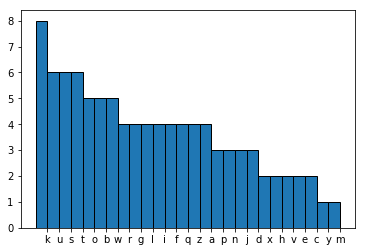

In [22]:
labels, values = zip(*frequency_table.most_common())
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width, edgecolor="black")
plt.xticks(indexes + width * 0.5, labels)
plt.show()


For comparison, here's the English language's letter frequency graph:

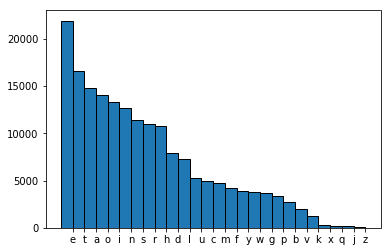

In [23]:
english_frequencies = Counter({'e' : 21912, 't' : 16587, 'a' : 14810, 'o':14003, 'i':13318, 'n':12666, 's':11450, 'r':10977, 'h':10795, 'd':7874, 'l':7253, 'u':5246, 'c':4943, 'm':4761, 'f':4200, 'y':3853, 'w':3819, 'g':3693, 'p':3316, 'b':2715, 'v':2019, 'k':1257, 'x':315, 'q':205, 'j':188, 'z':128})
labels, values = zip(*english_frequencies.items())
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width, edgecolor="black")
plt.xticks(indexes + width * 0.5, labels)
plt.show()

The data was sourced from [this website](http://pi.math.cornell.edu/~mec/2003-2004/cryptography/subs/frequencies.html), based on a sample of 40000 words.

As an aside: note that the maximum frequency of K4 is 8 — there's simply not that many letters to look at. **But what if we took the true letter frequencies of the English language, and quantized them into a 0-8 relative scale?**

To see this in action:

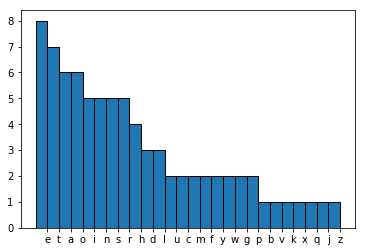

In [24]:
e_max = english_frequencies.most_common(1)[0][1]
partitions = 8 # equivalent to calling 'k4.most_common(1)[0][1]''
english_quantized = {k: np.ceil(v / e_max * 8) for k, v in english_frequencies.items()} # yes, I'm being sloppy with ceilings
labels, values = zip(*english_quantized.items())
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width, edgecolor="black")
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Hmmmm. That's a little close, but not enough to convince me.

As a next step, let's try doing a [Kolmogorov-Smirnov analysis](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) on our sample of English letters vs. K4 based on frequency rank. That'll tell us the likelihood that the characters in K4 are sampled from an English alphabet with similar frequencies to natural English. **THIS DOES NOT SAY THIS A MONOALPHABETIC CIPHER WAS USED,** just that the encryption techniques did not change the underlying letter distribution.

First, convert the frequency dictionaries to store relative instead of absolute frequency (% of a certain character instead of #):

In [25]:
n_english = sum(english_frequencies.values())
n_kryptos = sum(frequency_table.values())
english_relative_freq = {k:(v/n_english) for k, v in english_frequencies.items()}

temp = {k:(v/n_kryptos) for k, v in frequency_table.items()}
kryptos_relative_freq = dict(sorted(temp.items(), key=lambda x: x[1], reverse=True))

print("English language: ",english_relative_freq)
print('\n')
print("Kryptos 4: ", kryptos_relative_freq)

English language:  {'e': 0.12019549870270922, 't': 0.09098588613462202, 'a': 0.08123837786542185, 'o': 0.07681168165087793, 'i': 0.07305420097310522, 'n': 0.06947773761265585, 's': 0.06280752373795274, 'r': 0.06021294218965129, 'h': 0.05921460425774672, 'd': 0.043191828988003486, 'l': 0.03978541219837304, 'u': 0.02877626808116158, 'c': 0.027114199985738028, 'm': 0.02611586205383345, 'f': 0.02303856765933638, 'y': 0.021135143140815018, 'w': 0.020948640450239437, 'g': 0.020257483420459344, 'p': 0.018189497704371293, 'b': 0.014892788379785303, 'v': 0.011074968596238131, 'k': 0.006895114178044245, 'x': 0.0017278925744502285, 'q': 0.0011245015167057042, 'j': 0.0010312501714179142, 'z': 0.0007021277762845373}


Kryptos 4:  {'k': 0.08247422680412371, 'u': 0.061855670103092786, 's': 0.061855670103092786, 't': 0.061855670103092786, 'o': 0.05154639175257732, 'b': 0.05154639175257732, 'w': 0.05154639175257732, 'r': 0.041237113402061855, 'g': 0.041237113402061855, 'l': 0.041237113402061855, 'i': 0

Just by eyeballing it, the Kryptos 4 distribution seems a little "flatter." Let's confirm this with some graphs: 

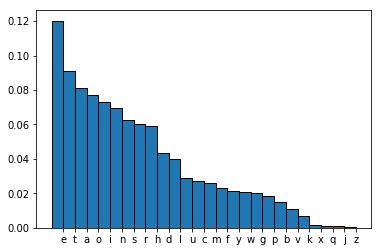

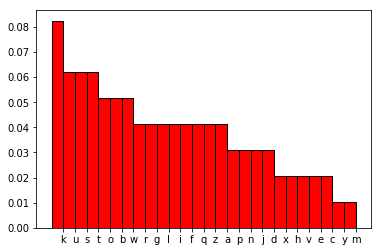

In [26]:
labels, values = zip(*english_relative_freq.items())
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width, edgecolor="black")
plt.xticks(indexes + width * 0.5, labels)

plt.show()

labels2, values2 = zip(*kryptos_relative_freq.items())
indexes2 = np.arange(len(labels2))
width2 = 1

plt.bar(indexes2, values2, width2, edgecolor="black", color="red")
plt.xticks(indexes2 + width2 * 0.5, labels2)

plt.show()

That seems right. Now for the test.

**Null hypothesis:** The distributions of the two samples are the same.

In [27]:
import scipy.stats as stats
stat = stats.ks_2samp(list(english_relative_freq.values()), list(kryptos_relative_freq.values()))
print(stat)


Ks_2sampResult(statistic=0.30769230769230765, pvalue=0.1382739894213808)


Since `pvalue > 0.05`, we fail to reject the null hypothesis. This means there's a non-trivial chance that the letters come from the same distribution, but it does not **prove** or **disprove** it. Statistically speaking, we would not be "surprised" to see this result *given* the two distributions are the same.

This leads to a key hypothesis: that the masking and encoding techniques do not alter the rank-order frequency distribution of the plaintext.

$\therefore$ 
### Thesis 1: The masking and encoding techniques used in the construction of K4 do not alter the rank-order frequency distribution of the plaintext.

Let's do more analysis! We can calculate the [index of coincidence](https://en.wikipedia.org/wiki/Index_of_coincidence) (IC) of these letters. These are particularly useful for teasing out Vigénere keyword length. The non-normalized IC of the English language is approximately 0.0667. The normalized (non-normalized * # of alphabetic characters) IC is 1.73.

I've written a method for calculating the IC given texts, given below:

In [28]:
def calculateIC(string, ignore_case=True, alphabet=string.ascii_lowercase):
    if (ignore_case):
        string = string.lower()
    counter = frequencies(string, ignore_case, alphabet)
    ic = 0
    n_chars = 0
    for k in counter:
        ic += counter[k] * (counter[k] - 1)
        n_chars += counter[k]
    return ic / (n_chars * (n_chars-1))

ic_k4= calculateIC(k4)
print("Non-normalized:", ic_k4)
print("Normalized:", ic_k4 * len(string.ascii_uppercase))

Non-normalized: 0.03608247422680412
Normalized: 0.9381443298969071


This is a bit on the low side, unfortunately. However, we can "slice" the string by taking every other character and calculating IC on those slices:

In [29]:
ic_k4_slice2_0 = calculateIC(k4[::2])
print("Non-normalized, starting at 0, slice size 2:", ic_k4_slice2_0)
print("Normalized, starting at 0, slice size 2:", ic_k4_slice2_0 * len(string.ascii_uppercase))
print("\n")

ic_k4_slice2_1 = calculateIC(k4[1::2])
print("Non-normalized, starting at 1, slice size 2:", ic_k4_slice2_1)
print("Normalized, starting at 1, slice size 2:", ic_k4_slice2_1 * len(string.ascii_uppercase))

Non-normalized, starting at 0, slice size 2: 0.03231292517006803
Normalized, starting at 0, slice size 2: 0.8401360544217688


Non-normalized, starting at 1, slice size 2: 0.038120567375886524
Normalized, starting at 1, slice size 2: 0.9911347517730497


Feel free to mess around with the below thing to explore other slice sizes:

In [58]:
step = 7
code = k4.replace("K","E").replace("U","T").replace("S","A")

# boilerplate
def findICs(step, code):
    sum_ic = 0
    for i in range(step):
        test_slice_ic = calculateIC(code[i::step])
        sum_ic += test_slice_ic
        print("Non-normalized, starting at", i, ", slice size", step, ":", test_slice_ic)
        print("Normalized, starting at", i, ", slice size", step, ":", test_slice_ic * len(string.ascii_uppercase))
        print("\n")
    print("Average non-normalized IC:", sum_ic / step)
    print("Average normalized IC:", len(string.ascii_uppercase) * sum_ic / step)
    return sum_ic

sum_ic = findICs(step, code)


    


Non-normalized, starting at 0 , slice size 7 : 0.06593406593406594
Normalized, starting at 0 , slice size 7 : 1.7142857142857144


Non-normalized, starting at 1 , slice size 7 : 0.03296703296703297
Normalized, starting at 1 , slice size 7 : 0.8571428571428572


Non-normalized, starting at 2 , slice size 7 : 0.07692307692307693
Normalized, starting at 2 , slice size 7 : 2.0


Non-normalized, starting at 3 , slice size 7 : 0.10989010989010989
Normalized, starting at 3 , slice size 7 : 2.857142857142857


Non-normalized, starting at 4 , slice size 7 : 0.054945054945054944
Normalized, starting at 4 , slice size 7 : 1.4285714285714286


Non-normalized, starting at 5 , slice size 7 : 0.04395604395604396
Normalized, starting at 5 , slice size 7 : 1.142857142857143


Non-normalized, starting at 6 , slice size 7 : 0.0641025641025641
Normalized, starting at 6 , slice size 7 : 1.6666666666666665


Average non-normalized IC: 0.06410256410256411
Average normalized IC: 1.6666666666666667


The NSA documents requested via FOIA (will provide link when I find one) confirm that there seems to be higher IC with step size 7 (average normalized IC of 1.08); however, it's not a very strong effect since it's so close to 1. Set `step_size = 7` and see for yourself. 

However, if it is true that the masking and encoding techniques don't overall touch the frequency distribution, we should be seeing an IC close in value to that of the raw K4 text coinciding with some keyword size n **if** Vigénere encryption techniques were used. Note that K3 has IC = 1.720, very close to natural English!

Also, it is interesting to note that K1 has IC values similar to that of K4: the IC of K1 is `0.03789042498719918`, but the IC of K4 is `0.03608247422680412`, approximately a 5% difference. Due to the shorter nature of these strings, however, there is more uncertainty when speculating.

As a sanity check, feel free to run the code on K1 with the key-length of "PALIMPSEST" (10). You'll find very high ICs. A similar effect is visible on K2 with the key-length of "ABSCISSA" (8). The fact that no similar strong pattern emerges **strongly suggest that this is not a pure Vigenere encrypted polyalphabetic substitution cipher** — but that was generally accepted already.

But what if there is some decryption technique that leads to a middle-text digestible by modern cryptanalytic methods? In other words, if we find $g^{-1}$ and apply it to k4, we should reach some intermediary text that yields better IC values if the masking technique is a Vigenere cipher. The masking technique used ought to leave some statistical fingerprint, traces of which can be found after encryption.

So the question now is — what sort of transformations on k4 yield statistically interesting text? Furthermore, if we maintain consistency with **Thesis 1**, what such transformations do not change the underlying rank-order distribution of frequencies? Making use of the observation that the ciphertext distribution seems "squashed" - what transformations exist to squeeze/unsqueeze (?) entropy from a text?

## Step 1: Deducing the Frequency Distribution of the Middletext

Given the provided ciphertext, what masking methods would confound frequency analysis on enconded English?

To start, what if we replaced the nth-most common letter in the ciphertext with the nth-most common letter in English? What masking methods would confound that assumption?

If the masking technique verticalliy "squashes" the rank-order distribution of frequencies, then we would expect the medium-frequency letters of the alphabet to be the least affected. We don't know what "masking" techniques were used to disguise the plaintext, but confounding frequency analysis (a staple of cryptanalysis) would certainly be pretty powerful. 

Imagine an English plaintext $s$ masked with $f$ to conceal frequencies ($f(s) = s'$), resulting in a squashed frequency distribution of $s'$. Then, $g(s') = k4$ by definition. Suppose that $g$ is a transposition. Combining this logic with the previous, this results in the following hypotheses:

### H1.1. If encoding function g is a transposition, then the rank-order frequency distribution of s' should be similar to that of natural English close to the median of the distribution.

Similarly, for some Vigenere cipher $g$:

### H1.2. If encoding function g is a Vigenere polyalphabetic substitution cipher, then for some keyword k, decoding k4 using k results in middletext s' with a rank-order frequency distribution similar to that of natural English close to the median of the distribution.

In other words, whatever encoding technique was used, we should end up with a squished-frequency distribution upon executing $g^{-1}$. 


In [131]:
decodeVigenere(k4.replace("K","E").replace("U","T").replace("S","A"), "BLINKED", tabula_kryptos)

'WLVBTQHWVZELWWWKKNBWGTKFPQCNNYXMAVUVSIRAODZJVMZHGZGRMLNKAJBVNRXEEHPTNBLUHMWYKPBCEJXKAVVEHNWVQVJAJ'

## Attempts at Decryption

### Method 1: Autokey Deduction via N-Gram Fitness Test

**Description.** The Autokey cipher is a modification of the Vigenere cipher that uses part of the plaintext itself as the encryption key, offset by another keyword. More information on the Autokey cipher can be found [here](http://practicalcryptography.com/ciphers/classical-era/autokey/).  

**Methods.** We will assume that for some keyword of length n, Kryptos 4 is enciphered using its own plaintext using the Kryptos Vigenere tableau. Using a starting key of 'A'^n (A repeated n times), we will use n-gram fitness to calculate the most likely keys for a particular key-length. 

Using the general technique described [here](http://practicalcryptography.com/cryptanalysis/stochastic-searching/cryptanalysis-autokey-cipher/), we increment the first 'A' until we find the first character that maximizes the n-gram fitness function. We fix that character, then repeat the same process with the next character. For an alphabet $\Sigma$, this reduces search space from $|\Sigma|^n$ to $|\Sigma| \times n$, an asymptotic improvement. I imagine that for $n \geq 6$, the exponential version gets extremely computationally expensive for the average user. 

We can also keep on hand a dictionary data structure that can tell if our keyword makes sense in English. This is setting should be toggle-able.

To calculate fitness, we find the n-gram fitness of every window of size $1 \leq i \leq n$ starting at every nth character. That is to say we do not include the non-decrypted letters in the n-gram fitness calculation. We only have n-gram data up to size 5. 

First, let's load in our n-gram fitness tables:

Data retrieved from [Practical Cryptography](http://practicalcryptography.com/cryptanalysis/letter-frequencies-various-languages/english-letter-frequencies/).

In [87]:
from kryptos.util.constants import RES_PATH

def loadDict(file):
    d = {}
    with open(RES_PATH + file) as f:
        for line in f:
            (key, val) = line.split()
            d[key] = int(val)
    return d

print("Loading 1-grams...")
_1_grams = loadDict("english_monograms.txt")
print("Loading 2-grams...")
_2_grams = loadDict("english_bigrams.txt")
print("Loading 3-grams...")
_3_grams = loadDict("english_trigrams.txt")
print("Loading 4-grams...")
_4_grams = loadDict("english_quadgrams.txt")
print("Loading 5-grams...")
_5_grams = loadDict("english_quintgrams.txt")

print("Done!")
print(_2_grams)

# This can take a long time to load. There are a LOT of 5-grams!

Loading 1-grams...
Loading 2-grams...
Loading 3-grams...
Loading 4-grams...
Loading 5-grams...
Done!
{'TH': 116997844, 'HE': 100689263, 'IN': 87674002, 'ER': 77134382, 'AN': 69775179, 'RE': 60923600, 'ES': 57070453, 'ON': 56915252, 'ST': 54018399, 'NT': 50701084, 'EN': 48991276, 'AT': 48274564, 'ED': 46647960, 'ND': 46194306, 'TO': 46115188, 'OR': 45725191, 'EA': 43329810, 'TI': 42888666, 'AR': 42353262, 'TE': 42295813, 'NG': 38567365, 'AL': 38211584, 'IT': 37938534, 'AS': 37773878, 'IS': 37349981, 'HA': 35971841, 'ET': 32872552, 'SE': 31532272, 'OU': 31112284, 'OF': 30540904, 'LE': 30383262, 'SA': 30080131, 'VE': 29320973, 'RO': 29230770, 'RA': 28645577, 'RI': 27634643, 'HI': 27495342, 'NE': 27331675, 'ME': 27237733, 'DE': 27029835, 'CO': 26737101, 'TA': 26147593, 'EC': 25775798, 'SI': 25758841, 'LL': 24636875, 'SO': 23903631, 'NA': 23547524, 'LI': 23291169, 'LA': 23178317, 'EL': 23092248, 'MA': 21828378, 'DI': 21673998, 'IC': 21468412, 'RT': 21456059, 'NS': 21306421, 'RS': 21237259, 

In [86]:
import itertools # for the dynamic string slicing we need
import math

def loadTable(size):
    if size == 1:
        return _1_grams
    elif size == 2:
        return _2_grams
    elif size == 3:
        return _3_grams
    elif size == 4:
        return _4_grams
    elif size == 5:
        return _5_grams
        freqDict = loadDict("english_quintgrams.txt")
    else:
        return {}

def calculateFitness(string, ngram_size, step_size=1):
    if ngram_size < 1 or ngram_size > 5:
        return 0
    ngram_table = loadTable(ngram_size)
    sliced = [string[i:i+ngram_size] for i in range(0, len(string), step_size)]
    score = 0
    for value in sliced:
        try:
            score += math.log(ngram_table[value])
        except KeyError:
            pass
    return score

def analyzeNGramSlices(ciphertext, tabula=string.ascii_uppercase, start_key='AAAAAAA', alphabet=string.ascii_uppercase, verbose=False):
    key = ''
    length = len(alphabet)
    for i in range(len(start_key)):
        if i == 0:
            continue
        char_curr = start_key[i]
        fitness_max = -1
        max_char = None
        for char_index in range(length):
            char_curr = alphabet[(alphabet.index(start_key[i]) + char_index) % length]
            result = decodeVigenere(ciphertext, key + char_curr + ciphertext, tabula)
            fitness = calculateFitness(result, i, step_size=len(start_key))
            if fitness > fitness_max:
                fitness_max = fitness
                max_char = char_curr
            if verbose:
                print("Current key:", key + char_curr, "- Fitness:", fitness)
        key += max_char
    return key

init = 'AAAAAAA'

kryptos_tableau = tabulaOf("KRYPTOS", prepend=True, basis=string.ascii_uppercase)
best_key = analyzeNGramSlices(k4, tabula=kryptos_tableau, start_key=init, verbose=True)
best_plain = decodeVigenere(k4, best_key, kryptos_tableau)
print("Plaintext:", best_plain)




Current key: A - Fitness: 253.67507658384412
Current key: B - Fitness: 255.93050337744467
Current key: C - Fitness: 255.38637710727212
Current key: D - Fitness: 256.3151316335936
Current key: E - Fitness: 253.06559657052472
Current key: F - Fitness: 257.298935444334
Current key: G - Fitness: 256.25548949699515
Current key: H - Fitness: 256.76534757948997
Current key: I - Fitness: 253.8135918534624
Current key: J - Fitness: 257.32003445830134
Current key: K - Fitness: 257.33925396734156
Current key: L - Fitness: 256.92926500979246
Current key: M - Fitness: 256.0641342532903
Current key: N - Fitness: 256.1087425909325
Current key: O - Fitness: 255.1163947892369
Current key: P - Fitness: 255.87184014489816
Current key: Q - Fitness: 257.8216431239652
Current key: R - Fitness: 257.51905116518935
Current key: S - Fitness: 253.15502846208662
Current key: T - Fitness: 257.1744533969947
Current key: U - Fitness: 256.6822854465549
Current key: V - Fitness: 256.48069975643745
Current key: W - Fit

In [81]:
# sanity check
cipher = 'FMULRULKIJEFWPHPPOXMDENLGYEL'
analyzeNGramSlices(cipher, start_key='AAAAAAA')

'BVQTYA'

Extra statistics for the above calculation:

In [83]:
print(best_plain)
print("Frequencies:", frequencies(best_plain))
print("Index of Coincidence calculations:")
findICs(8, best_plain)

ERESTXTXXNTDHZJVXOHRBLKQYGOBDFNNLEHWPWOEZGFZVOBMPKIUCDRPKFSBZONXEVYWIWBOCNBMNNOLIUMPUSEKWHGHVOMKA
Frequencies: Counter({'o': 8, 'n': 7, 'e': 6, 'b': 6, 'x': 5, 'h': 5, 'k': 5, 'w': 5, 'z': 4, 'v': 4, 'p': 4, 'm': 4, 'r': 3, 's': 3, 't': 3, 'd': 3, 'l': 3, 'g': 3, 'f': 3, 'i': 3, 'u': 3, 'y': 2, 'c': 2, 'j': 1, 'q': 1, 'a': 1})
Index of Coincidence calculations:
Non-normalized, starting at 0 , slice size 8 : 0.02564102564102564
Normalized, starting at 0 , slice size 8 : 0.6666666666666666


Non-normalized, starting at 1 , slice size 8 : 0.030303030303030304
Normalized, starting at 1 , slice size 8 : 0.7878787878787878


Non-normalized, starting at 2 , slice size 8 : 0.015151515151515152
Normalized, starting at 2 , slice size 8 : 0.3939393939393939


Non-normalized, starting at 3 , slice size 8 : 0.030303030303030304
Normalized, starting at 3 , slice size 8 : 0.7878787878787878


Non-normalized, starting at 4 , slice size 8 : 0.015151515151515152
Normalized, starting at 4 , slice size 8 

0.25291375291375295

Ewwww. That's not very promising. But what if we have the hypothesized middletext $s'$, and have some masked text that can be unmasked and decrypted? Perhaps the masking technique, in squeezing frequnecies, swapped some character pairs.

We can try naively running through some Vigenere decryptions to see if we get any promising frequency distributions, but otherwise, I'm not sure how to proceed from here.

In [85]:
naive_key = "PYRAMID"

soln = decodeVigenere(best_plain, naive_key, kryptos_tableau)
freqs = frequencies(soln)
dict(sorted(freqs.items(), key=lambda x: x[1], reverse=True))

{'p': 8,
 'u': 7,
 'm': 6,
 'x': 6,
 'n': 6,
 'j': 6,
 'z': 5,
 'd': 5,
 'f': 5,
 'c': 5,
 'q': 5,
 'w': 5,
 'b': 4,
 'v': 4,
 'o': 4,
 'g': 3,
 't': 3,
 'a': 2,
 'r': 2,
 'e': 2,
 'i': 1,
 'h': 1,
 'y': 1,
 'k': 1}

### Method 2: Hill Cipher Decryption using BERLINCLOCK as a crib

I tried this on paper. Led to a bunch of fractions. Not very elegant.


### Method 3: Foursquare

To start, let's run 2-gram analysis on K4 and English.



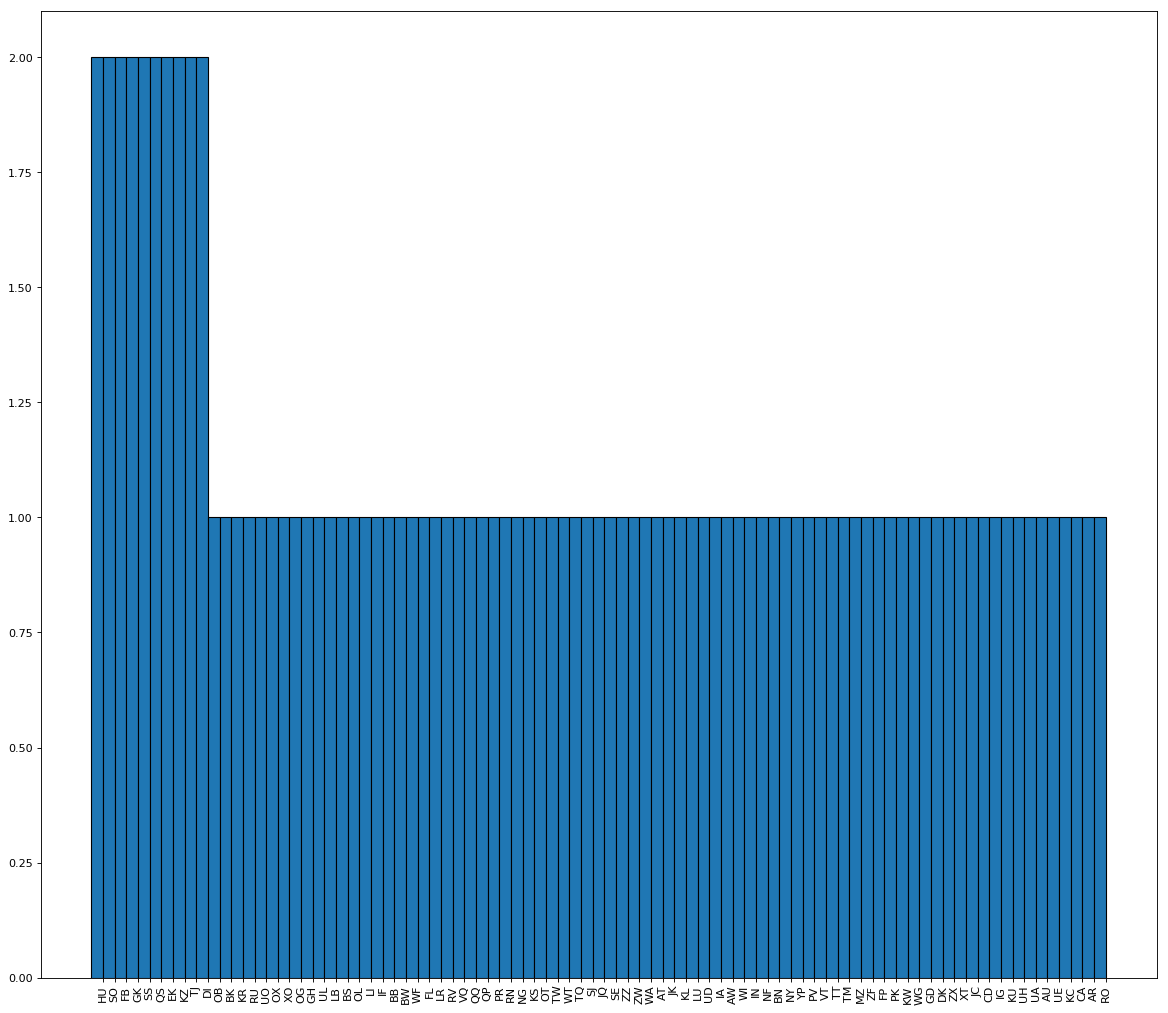

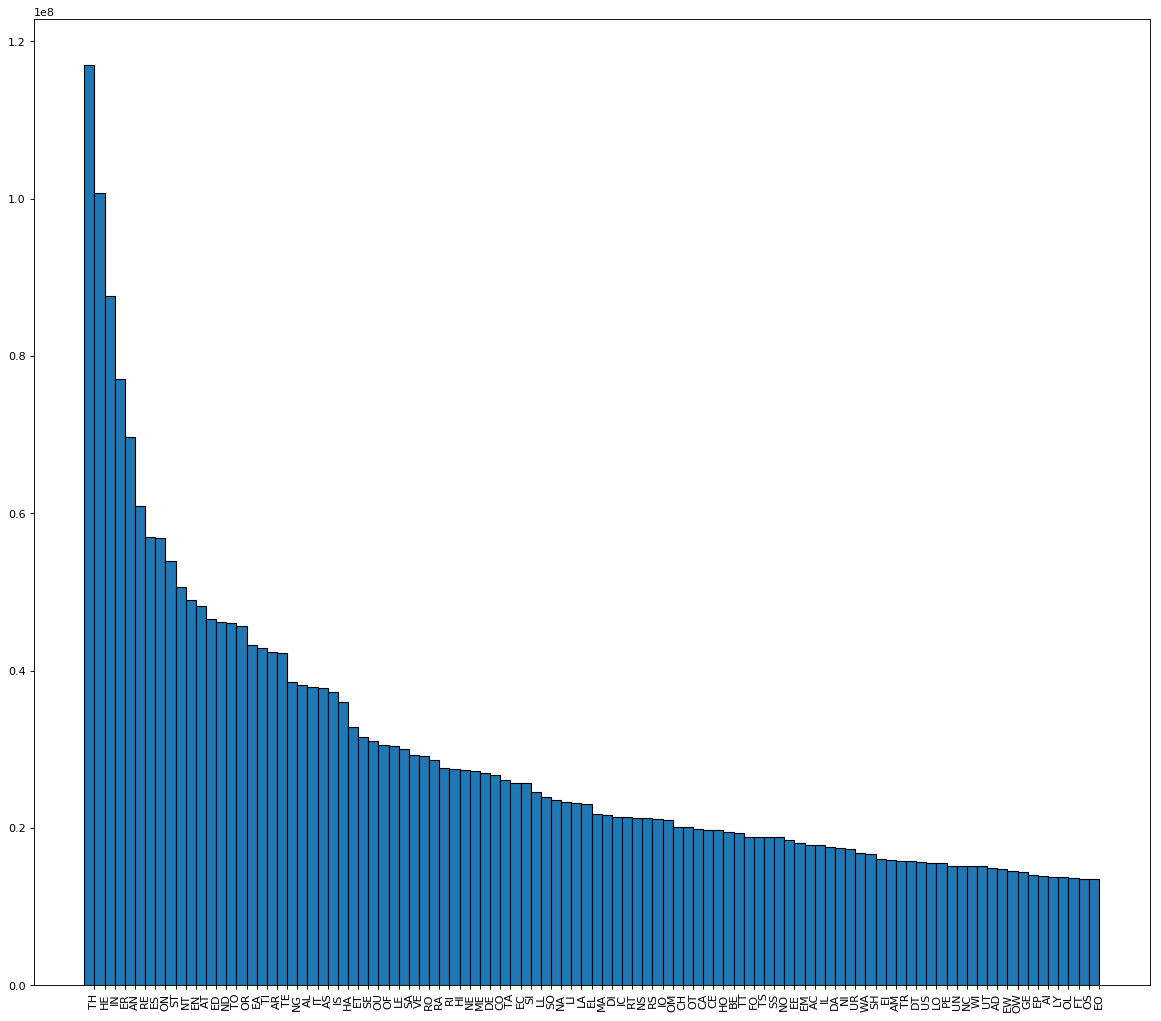

In [100]:
def nGramAnalysis(string, size):
    ngramCounts = {}
    len_string = len(string)
    string = string + string # padding the string
    for i in range(len_string):
        segment = string[i:i+size]
        if segment in ngramCounts:
            ngramCounts[segment] += 1
        else:
            ngramCounts[segment] = 1
    return dict(sorted(ngramCounts.items(), key=lambda x: x[1], reverse=True))

labels, values = zip(*nGramAnalysis(k4, 2).items())
indexes = np.arange(len(labels))
width = 1

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(indexes, values, width, edgecolor="black")
plt.xticks(indexes + width * 0.5, labels, rotation=90)

plt.show()

labels, values = zip(*dict(sorted(_2_grams.items(), key=lambda x: x[1], reverse=True)[:100]).items())
indexes = np.arange(len(labels))
width = 1

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(indexes, values, width, edgecolor="black")
plt.xticks(indexes + width * 0.5, labels, rotation=90)

plt.show()

As expected, 2-grams in English follow a Pareto distribution-like probability mass function, while the K4 corpus (which is pretty short) does...whatever it's doing up there. It looks nothing like the long tailed distribution of the English language. 

## Other Fun Coincidences

Recall the coordinates in the plaintext of K2: `38* 57' 6.5" N 77* 8' 44" W`. If we add up those digits, we get 64, and keeping a cumulative sum, nothing super-meaningful happens. 

However, if you begin summing from the **ordinate** of the coordinates (the second element of a coordinate system, the counterpart to the **abscissa**), you reach:

$7 + 7 + 8 + 4 + 4 + 3 + 8 + 5 + 7 + 6 + 5 + 7 + 7 + 8 + 4 + 4 + 3 = 97$

This is exactly the length of k4. 

The coordinates are very near Kryptos, which was likely intentional, and it would be very difficult to contrive a passphrase of this exact shape given real-world coordinates. But, as we know, the coordinates are slightly off. There's a lot of speculation about what it points to — *what if the discrepancy is intentional, and part of the message?*

$\therefore$

### Hypothesis S0 (S for silly): The key to solving K4 is in a phrase with exactly the shape described in the sum above.

Extra tinfoil: the length of Berlin is 6 and Clock is 5. 6 and 5 are next to each other in the above sum. Coincidence??? I dunno, probably.

Ok, tinfoil hat off. It is also incredibly unlikely for a phrase to take this shape given how common 2 and 3-letter words are. This also belies the masking => encryption model hinted at by JS.


#### Addendum to S0

However, as Page 10.1 of the uploaded field manual of cryptoanalysis [notes](https://xa.yimg.com/df/Kryptos/ch10.pdf?token=YVi-YsY3RpNZAtW4YdlyW2ODzeOQkQVrYEmusdKY4d5Fm1HFZKEP-3_gpwpUsU6yCRDSyWvLbYkQMqq7g9a5HWC28ZmVHwjhFJoYxd8_vNp9QcCeP_Smtwed35HeXdhFLJ1FpNdP31JU3TSyhIB3lmGyL4mzPCnzAHwUXfBXpIvs&type=download), the digits 3 through 8 (6 total digits) could be arranged in such a way with a keyword to produce a table like the diagram shown.  